<a href="https://colab.research.google.com/github/shafi21001/PRNG/blob/main/prng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

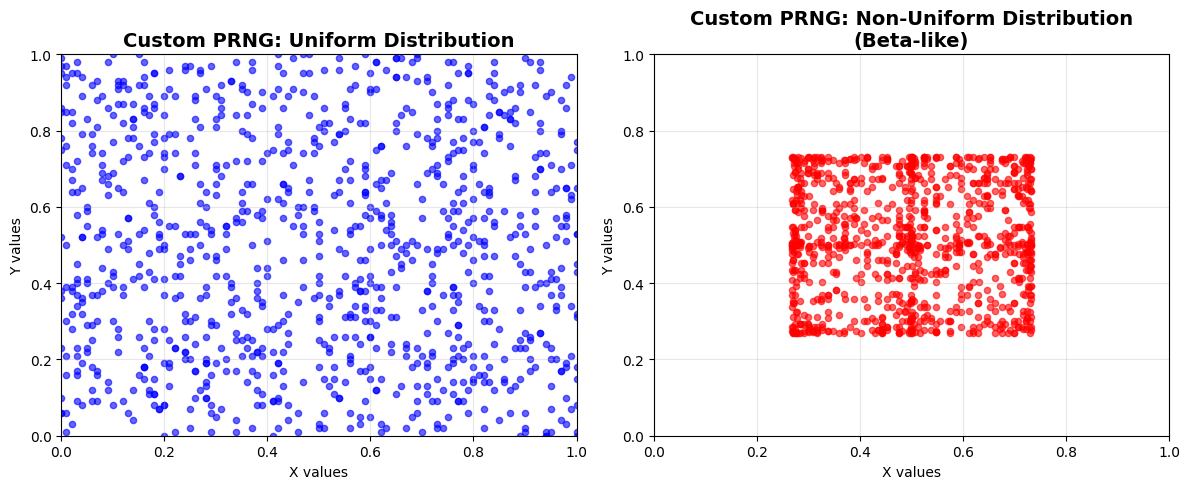

=== Custom PRNG Distribution Comparison ===
Uniform - Mean X: 0.497, Std X: 0.295
Uniform - Mean Y: 0.496, Std Y: 0.289
Beta-like - Mean X: 0.496, Std X: 0.152
Beta-like - Mean Y: 0.512, Std Y: 0.150


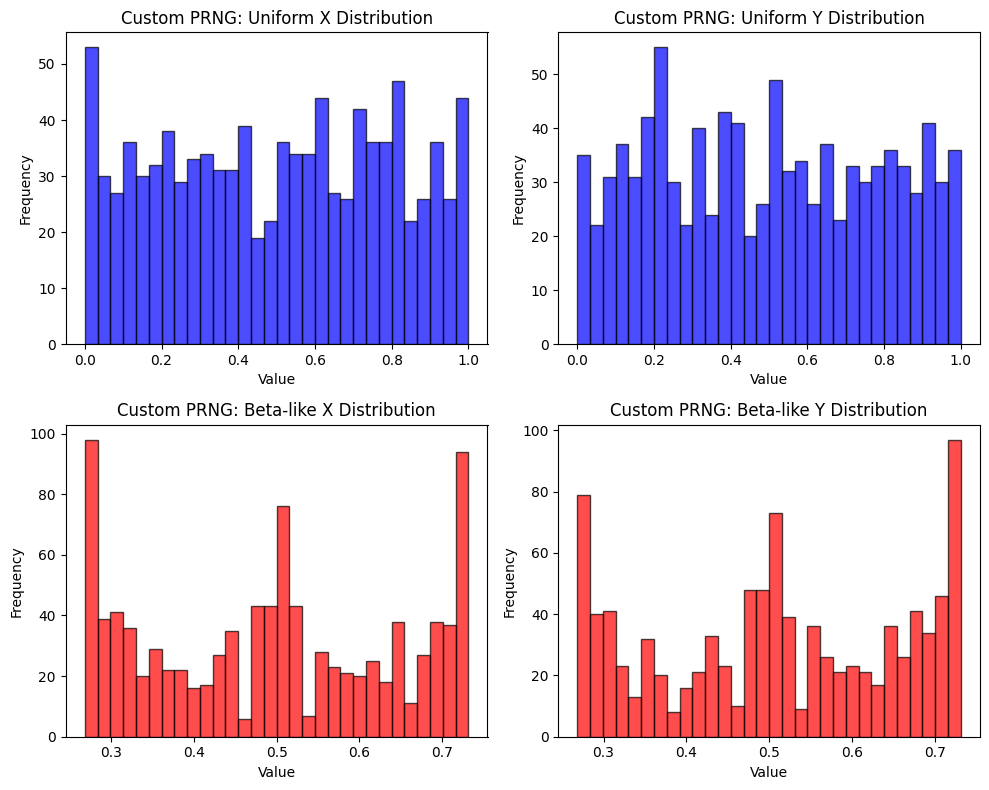


=== Comparison with NumPy (for reference) ===
NumPy Uniform - Mean X: 0.490, Std X: 0.292
NumPy Beta - Mean X: 0.493, Std X: 0.222

=== Uniformity Test (Chi-square) ===
Chi-square statistic: 15.720
P-value: 0.073
Uniform quality: Good (p > 0.05 indicates good uniformity)


In [8]:
import os
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class CustomPRNG:
    def __init__(self, count=1000):
        entropy = os.urandom(32)
        hashed = hashlib.sha256(entropy).hexdigest()
        self.state = int(hashed, 16) & 0xFFFFFFFF
        self.counter = 0
        self.count = count

    def next(self):
        self.state = (self.state ^ (self.state << 13)) & 0xFFFFFFFF
        self.state = (self.state ^ (self.state >> 17)) & 0xFFFFFFFF
        self.state = (self.state ^ (self.state << 5)) & 0xFFFFFFFF
        digest = hashlib.sha256(str(self.state + self.counter).encode()).hexdigest()
        self.counter += 1
        return int(digest, 16) % 101

    def generate_uniform(self):
        """Generate uniform distribution (0, 1)"""
        numbers = [self.next() for _ in range(self.count)]
        return np.array(numbers) / 100.0  # Normalize to [0, 1]

    def generate_beta_like(self, alpha=2, beta=2):
        """Generate beta-like distribution using rejection sampling"""
        # Generate uniform samples and transform to beta-like distribution
        uniform_samples = self.generate_uniform()

        # Reset counter for second set
        self.counter = 0
        uniform_samples_2 = self.generate_uniform()

        # Use Box-Muller-like transformation to create beta-like distribution
        # This creates clustering around 0.5 similar to Beta(2,2)
        transformed = []
        for i in range(len(uniform_samples)):
            # Transform uniform to beta-like using inverse transform sampling approximation
            u = uniform_samples[i]
            # Approximate Beta(2,2) using a simple transformation
            # Beta(2,2) has PDF: 6x(1-x) which peaks at x=0.5
            x = 0.5 + 0.4 * np.sin(2 * np.pi * u) * (1 - abs(2*u - 1))
            # Ensure bounds [0, 1]
            x = max(0, min(1, x))
            transformed.append(x)

        return np.array(transformed)

    def generate_distributions(self):
        """Generate both uniform and beta-like distributions"""
        # Generate uniform distribution
        uniform_x = self.generate_uniform()

        # Reset for second uniform set
        self.counter = 0
        uniform_y = self.generate_uniform()

        # Generate beta-like distribution
        self.counter = 0
        beta_x = self.generate_beta_like()

        self.counter = 0
        beta_y = self.generate_beta_like()

        return uniform_x, uniform_y, beta_x, beta_y


# Initialize and generate distributions
prng = CustomPRNG(count=1000)
uniform_x, uniform_y, beta_x, beta_y = prng.generate_distributions()

# Create subplots for scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Uniform distribution
ax1.scatter(uniform_x, uniform_y, alpha=0.6, s=20, color='blue')
ax1.set_title('Custom PRNG: Uniform Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('X values')
ax1.set_ylabel('Y values')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot 2: Non-uniform distribution
ax2.scatter(beta_x, beta_y, alpha=0.6, s=20, color='red')
ax2.set_title('Custom PRNG: Non-Uniform Distribution\n(Beta-like)', fontsize=14, fontweight='bold')
ax2.set_xlabel('X values')
ax2.set_ylabel('Y values')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.savefig('custom_prng_scatter.pdf')
plt.tight_layout()
plt.show()

# Print some statistics to compare
print("=== Custom PRNG Distribution Comparison ===")
print(f"Uniform - Mean X: {np.mean(uniform_x):.3f}, Std X: {np.std(uniform_x):.3f}")
print(f"Uniform - Mean Y: {np.mean(uniform_y):.3f}, Std Y: {np.std(uniform_y):.3f}")
print(f"Beta-like - Mean X: {np.mean(beta_x):.3f}, Std X: {np.std(beta_x):.3f}")
print(f"Beta-like - Mean Y: {np.mean(beta_y):.3f}, Std Y: {np.std(beta_y):.3f}")

# Additional visualization: Histograms to show distribution shapes
fig, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(10, 8))

# Histograms for uniform distribution
ax3.hist(uniform_x, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.set_title('Custom PRNG: Uniform X Distribution')
ax3.set_xlabel('Value')
ax3.set_ylabel('Frequency')

ax4.hist(uniform_y, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax4.set_title('Custom PRNG: Uniform Y Distribution')
ax4.set_xlabel('Value')
ax4.set_ylabel('Frequency')

# Histograms for beta-like distribution
ax5.hist(beta_x, bins=30, alpha=0.7, color='red', edgecolor='black')
ax5.set_title('Custom PRNG: Beta-like X Distribution')
ax5.set_xlabel('Value')
ax5.set_ylabel('Frequency')

ax6.hist(beta_y, bins=30, alpha=0.7, color='red', edgecolor='black')
ax6.set_title('Custom PRNG: Beta-like Y Distribution')
ax6.set_xlabel('Value')
ax6.set_ylabel('Frequency')

plt.savefig('custom_prng_histograms.pdf')
plt.tight_layout()
plt.show()

# Optional: Compare with numpy's built-in generators
print("\n=== Comparison with NumPy (for reference) ===")
np.random.seed(42)
numpy_uniform_x = np.random.uniform(0, 1, 1000)
numpy_uniform_y = np.random.uniform(0, 1, 1000)
numpy_beta_x = np.random.beta(2, 2, 1000)
numpy_beta_y = np.random.beta(2, 2, 1000)

print(f"NumPy Uniform - Mean X: {np.mean(numpy_uniform_x):.3f}, Std X: {np.std(numpy_uniform_x):.3f}")
print(f"NumPy Beta - Mean X: {np.mean(numpy_beta_x):.3f}, Std X: {np.std(numpy_beta_x):.3f}")

# Quality test: Chi-square test for uniformity
from scipy.stats import chisquare

# Test uniformity of our custom PRNG
bins = 10
uniform_hist, _ = np.histogram(uniform_x, bins=bins, range=(0, 1))
expected_freq = len(uniform_x) / bins
chi2_stat, p_value = chisquare(uniform_hist, expected_freq)

print(f"\n=== Uniformity Test (Chi-square) ===")
print(f"Chi-square statistic: {chi2_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Uniform quality: {'Good' if p_value > 0.05 else 'Poor'} (p > 0.05 indicates good uniformity)")